$$ \huge \text{ Binomial Option Pricing Model} $$
$$ \text{By JZ}$$

### Target : Visualization of the Binomial tree  

#### You need to install graphviz : pip install graphviz
for more info see : https://graphviz.readthedocs.io/en/stable/index.html

In [1]:
import logging
import graphviz
import math
logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.INFO)
graphviz.__version__, graphviz.version()

('0.20.3', (2, 50, 0))

In [2]:
class Node:
    '''
      Node to be used in the Binomial tree
    '''
    def __init__(self,name,stock,option_type,strike):
        # info to describe the tree
        self.name = name
        self.parent=None
        self.children=[]

        # info for pricing
        self.option_type=option_type
        self.stock=stock
        self.payoff=None
        self.option= 0.0
        self.delta= 0.0

        if option_type.upper()=="CALL":
            self.payoff=max(stock-strike,0.0)
        elif option_type.upper()=="PUT":
            self.payoff= max(strike-stock,0.0)
  
    def add_child(self,node):
        '''
            Us to express relationship between Nodes
        '''
        node.parent = self
        self.children.append(node)
    
    def __repr__(self):
        '''
        Use for debugging.if you want to call print(node) 
        '''
        return f"{self.name}"

#_________________________________________________________________________________________________________________________________________________

def create_tree(N=3,stock=100.0,vol=0.2,strike=100.0,rate=0.05,option_type="CALL",expiration=1.0,european_style=True):
    '''
        Create the Binomial tree.
        Return the root node.

        time_step = expiration / N 
        u = 1 + vol*sqrt(time_step)
        v = 1 - vol*sqrt(time_step)
        p_prime = 0.5+rate*sqrt(time_step)/(2*vol)
        df = 1.0/(1+rate*time_step)

        two mains steps:
            - forward : compute the stock value at each node using u and v  and the payoff
            - backward: compute the option value at each node using the children nodes
    '''

    # Create the root node - the one that we are going to return 
    root_node = Node(name="S",stock=stock,option_type=option_type,strike=strike)

    # set the variables for the run 
    USflag=0.0
    if not european_style:
        USflag=1.0
    time_step = expiration/float(N)
    u = 1+vol*math.sqrt(time_step)
    v = 1-vol*math.sqrt(time_step)
    p_prime = 0.5+rate*math.sqrt(time_step)/(2.0*vol)
    df = 1.0/(1.0+rate*time_step)
    
    # Generate nodes with u and v : Multiply the stock price by the number of time of u and v required
    # we create a list wich contain list of node at each steps.
    # iteration = 0 : steps_nodes = [ [root] ]
    # iteration = 1 : steps_nodes = [ [root], [uS,dS] ]
    # iteration = 2 : steps_nodes = [ [root], [uS,dS],[uuS,udS,ddS] ]
    # etc...
    
    # Store all the nodes at each steps
    steps_nodes=[[root_node]]

    # Iter on the number of steps 
    for i in range(1,N+1):
        step_nodes=[]
        # Iter on each node at each steps
        for j in range(0,i+1):

           # Generate the name like : uS, dS, uuS, udS, ddS, etc...
           us = ["u"]*(i-j)
           if len(us) < i:
            ds = ["d"]*(i-len(us))
            name = us+ds
           else:
               name = us
           name = ''.join(name)
            
           # compute the value stock
           spot=stock
           for s in name:
               if s=="u":
                   spot*=u
               elif s=="d":
                   spot*=v
                   
           # Create the node 
           node= Node(name+"S",spot,option_type,strike)

           # Save the node in the list of node for the current step 
           step_nodes.append(node)

        # Save the list of the nodes for the current steps
        steps_nodes.append(step_nodes)
    
    # Create links between the nodes
    # iter on the list of list 
    for i in range(0,len(steps_nodes)-1):
          for j in range(0,len(steps_nodes[i])):

              # current node
              node = steps_nodes[i][j]

              # add children
              node.add_child(steps_nodes[i+1][j])
              node.add_child(steps_nodes[i+1][j+1])

    # Init nodes at expiry 
    nodes = steps_nodes[-1]
    for node in nodes:
        node.option = node.payoff

    #_____________________________________________________
    # we initialized the tree:
    #            1- at each node with have the stock value (compute by mutipliying u and d with S)
    #            2- at each node we computed the payoff 
    # Compute Delta and Option  
    for i in range(len(steps_nodes)-2,-1,-1):
        for j in range(0,len(steps_nodes[i])):
                node = steps_nodes[i][j]
                child_1 = node.children[0]
                child_2 = node.children[1]

                # Compute delta  
                node.delta = (child_1.option - child_2.option)/(child_1.stock-child_2.stock)

                # Compute Option 
                node.option =max(df*(p_prime*child_1.option+(1-p_prime)*child_2.option),USflag*node.payoff)
    return root_node         


## Helper functions to represent the Binomial tree with GraphViz

In [3]:
def _add_edges(f,root,visited):
    for node in root.children :
        key= f"{root.name}_{node.name}"
        if key in visited :
                continue
        else:
            visited[key] = 1

        # payoff
        color="grey"
        if node.payoff>0.0:
            color="green"
        if node.payoff<0.0:
            color="black"

        # Option
        color_option="grey"
        if node.option>0.0:
            color_option="green"
        if node.option<0.0:
            color_option="black"
       
        f.node(node.name,label=f'''<<TABLE>
                             <TR>
                               <TD>{node.name}</TD>
                             </TR>
                             <TR>
                               <TD>Spot:{round(node.stock,2)}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="{color}">payoff:{round(node.payoff,4)}</TD>
                             </TR>
                             <TR>
                               <TD>delta:{round(node.delta,4)}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="{color_option}">Option:{round(node.option,4)}</TD>
                             </TR>

                            </TABLE>>''')
        #f.edge(root.name, node.name, label='p=0.5')
        f.edge(root.name, node.name)
        _add_edges(f,node,visited)

#_________________________________________________________________________________________________________________________________________________

def generate_graph(stock=100.0, vol=0.2,rate=0.05,strike=100.0,option_type="CALL",expiration=1.0,european_style=True,N=4):
    f = graphviz.Digraph('finite_state_machine', filename='fsm.gv')
    f.attr(rankdir='LR', size='10')
    f.attr('node', shape='circle')

    # Variable to set 
    time_step = expiration/float(N)
    u = 1+vol*math.sqrt(time_step)
    v = 1-vol*math.sqrt(time_step)
    p_prime = 0.5+rate*math.sqrt(time_step)/(2.0*vol)
    df = round(1.0/(1.0+rate*time_step),4)
    root_node = create_tree(N,stock,vol,strike,rate,option_type,expiration,european_style)

    f.node('S',label=f'''<<TABLE>
                             <TR>
                               <TD>Root</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="orange">spot:{round(stock,2)}</TD>
                             </TR>
                             <TR>
                               <TD>vol:{vol}</TD>
                             </TR>
                             <TR>
                               <TD>strike:{strike}</TD>
                             </TR>
                             <TR>
                               <TD>expiration:{expiration}</TD>
                             </TR>
                             <TR>
                               <TD>european_style:{european_style}</TD>
                             </TR>
                             <TR>
                               <TD>time_step:{time_step}</TD>
                             </TR>
                             <TR>
                               <TD>u:{u}</TD>
                             </TR>
                              <TR>
                               <TD>v:{v}</TD>
                             </TR>
                              <TR>
                               <TD>p_prime:{p_prime}</TD>
                             </TR>
                              <TR>
                               <TD>df:{df}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="orange">payoff:{round(root_node.payoff,4)}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="green">delta:{round(root_node.delta,4)}</TD>
                             </TR>
                             <TR>
                               <TD bgcolor="red">Option:{round(root_node.option,4)}</TD>
                             </TR>
                            </TABLE>>''')
    f.attr('node', shape='circle')
    visited={}
    _add_edges(f,root_node,visited)
    return f 

# Show Graph 

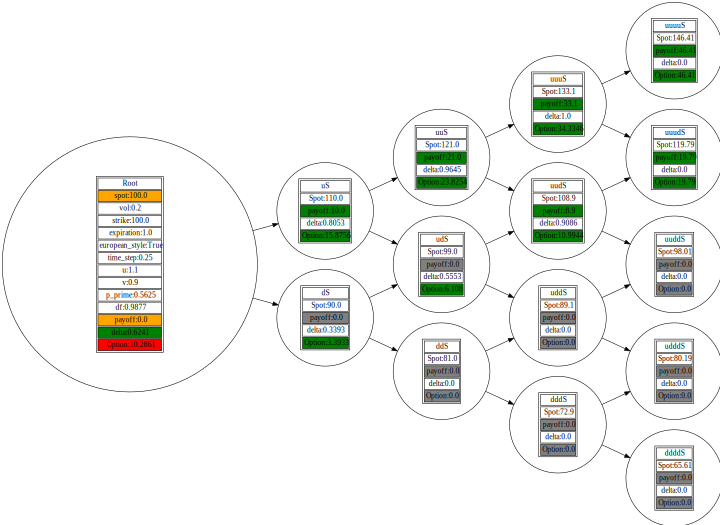

In [4]:
generate_graph(stock=100.0, vol=0.2,rate=0.05,strike=100.0,option_type="CALL",expiration=1.0,european_style=True,N=4)